# 1. Understand the environment

In [1]:
"""
Unimportant parameters of environment:
m = 1.0 
dt = 0.05 distance time 
l = 1.0 rod length

Important parameters of environment:
th = angle in radians normalized between [-pi, pi] with 0 being in the upright position
thdot = angular velocity of free end
x = cos(th) aka coordinate of free end
y = sin(th) aka coordinate of free end
u = torque in Nm (+ve counter-clockwise) applied to free end. Will clip e.g. if 3, will clip to 2.
g = acceleration of gravity in m**2. Default value is 10.0. Can change e.g. gym.make('Pendulum-v1', g=9.81)

Observation space:
| 0   | x         | -1.0 | 1.0 |
| 1   | y         | -1.0 | 1.0 |
| 2   | thdot     | -8.0 | 8.0 |

Action space: 
| 0   | u       | -2.0 | 2.0 |

Transition dynamics (clips if outside bounds)
new_thdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
new_th = th + newthdot * dt

Reward:
r = -(th**2 + 0.1 * thdot**2 + 0.001 * u**2)
Min reward = -(pi**2 + 0.1 * 8**2 + 0.001 * 2**2) = -16.2736044
Max reward = 0 when upright with zero velocity and no torque applied 

Starting state:
Random theta in [-pi, pi] and a random theta_dt in [-1,1]

Termination:
Episode terminates at 200 time steps and will never terminate before this even if upright
"""

"\nUnimportant parameters of environment:\nm = 1.0 \ndt = 0.05 distance time \nl = 1.0 rod length\n\nImportant parameters of environment:\nth = angle in radians normalized between [-pi, pi] with 0 being in the upright position\nthdot = angular velocity of free end\nx = cos(th) aka coordinate of free end\ny = sin(th) aka coordinate of free end\nu = torque in Nm (+ve counter-clockwise) applied to free end. Will clip e.g. if 3, will clip to 2.\ng = acceleration of gravity in m**2. Default value is 10.0. Can change e.g. gym.make('Pendulum-v1', g=9.81)\n\nObservation space:\n| 0   | x         | -1.0 | 1.0 |\n| 1   | y         | -1.0 | 1.0 |\n| 2   | thdot     | -8.0 | 8.0 |\n\nAction space: \n| 0   | u       | -2.0 | 2.0 |\n\nTransition dynamics (clips if outside bounds)\nnew_thdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt\nnew_th = th + newthdot * dt\n\nReward:\nr = -(th**2 + 0.1 * thdot**2 + 0.001 * u**2)\nMin reward = -(pi**2 + 0.1 * 8**2 + 0.001 * 2**2) = -16.

# 2. Imports and prequesites

In [2]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Runs on GPU if available, otherwise runs on CPU

# 3. Test the environment

In [3]:
env = gym.make('Pendulum-v1')
env.seed(0)
print('Start state:', env.reset())
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)
print('Step:', env.step([1.25]))
print('State:', env.state)
action = env.action_space.sample()
print('Action list:', action)
print('Action item:', action.item())

Start state: [-0.9422352  -0.33495203  0.9307819 ]
Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action space: Box([-2.], [2.], (1,), float32)
Step: (array([-0.9268331, -0.3754736,  0.8670679], dtype=float32), -7.928412733658928, False, {})
State: [-2.75668495  0.86706786]
Action list: [-1.100866]
Action item: -1.1008659601211548


# 4. Define the neural network¶

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, s_size, h_size, a_size):
        super(PolicyNetwork, self).__init__() 
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        self.fc3 = nn.Linear(h_size, a_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        params = (self.fc3(x))
        return params

# 5. Instantiate the neural network

In [5]:
policy = PolicyNetwork(s_size = 3, h_size = 64, a_size = 2)
optimizer = optim.Adam(policy.parameters(), lr=0.001) 

# 6. Define the algorithm to be used

In [6]:
def reinforce(n_episodes=10000, gamma=1.0, print_every=100):

    scores = []
    scores_deque = deque(maxlen=print_every) 
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        discounted_rewards = []
        saved_log_probs = []
        
        terminal = False 
        step = 1
        
        while not terminal:
            state = torch.from_numpy(state).float()
            params = policy(state) 
            mu = F.tanh(params[0]) * 2
            sigma = F.softplus(params[1])
            distribution = Normal(mu, sigma)
            action = distribution.sample()
            log_prob = distribution.log_prob(action)
            saved_log_probs.append(log_prob)
            next_state, reward, terminal, done = env.step([action])
            discounted_reward = reward*(gamma**step)
            discounted_rewards.append(discounted_reward)
            
            if done == True:
                terminal = True
            else: 
                step = step + 1
                state = next_state
        
        G = sum(discounted_rewards)
        scores_deque.append(G)
        scores.append(G)
        
        rewards_togo = []
        for t in range(1, step): 
            rewards_togo.append(sum(discounted_rewards))
            discounted_rewards.pop(0)
        
        
        policy_loss = []

        for t in range(1, step): 
            policy_loss.append(-saved_log_probs[t-1] * rewards_togo[t-1])
        
        policy_loss = torch.stack(policy_loss).sum() #Concatenates then sums the list? Stack?
        optimizer.zero_grad() #Sets the gradients of all optimized tensors to 0?
        policy_loss.backward() #Computes policy gradients with respect to all parameters?
        optimizer.step() #Update the parameters in the neural network
        
        if i_episode % print_every == 0: 
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    return scores

# 7. Train the agent

In [7]:
scores = reinforce()

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: -1551.86
Episode 200	Average Score: -1464.87
Episode 300	Average Score: -1494.51
Episode 400	Average Score: -1277.82
Episode 500	Average Score: -1270.94
Episode 600	Average Score: -1411.43
Episode 700	Average Score: -1373.99
Episode 800	Average Score: -1448.27
Episode 900	Average Score: -1506.90
Episode 1000	Average Score: -1317.57
Episode 1100	Average Score: -1310.46
Episode 1200	Average Score: -1238.40
Episode 1300	Average Score: -1206.16
Episode 1400	Average Score: -1229.77
Episode 1500	Average Score: -1186.03
Episode 1600	Average Score: -1171.79
Episode 1700	Average Score: -1150.63
Episode 1800	Average Score: -1104.28
Episode 1900	Average Score: -1091.57
Episode 2000	Average Score: -1117.97
Episode 2100	Average Score: -1120.20
Episode 2200	Average Score: -1125.80
Episode 2300	Average Score: -1133.62
Episode 2400	Average Score: -1190.77
Episode 2500	Average Score: -1094.72
Episode 2600	Average Score: -1122.56
Episode 2700	Average Score: -1137.59
Episode 28

# 8. Plot rewards over episodes

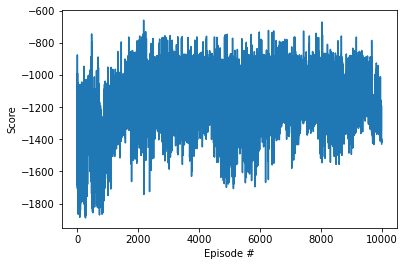

In [8]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# 9. Test the trained agent

In [9]:
for i in range(10):
    state = env.reset()
    ep_reward = 0
    terminal = False 
    step = 1 

    while not terminal:
        env.render()
        state = torch.from_numpy(state).float()
        params = policy(state) 
        mu = F.tanh(params[0]) * 2
        sigma = F.softplus(params[1])
        distribution = Normal(mu, sigma)
        action = distribution.sample()
        next_state, reward, terminal, done = env.step([action])
        ep_reward = ep_reward + reward
        print("Step:", step)
        print("Action:", action)
        print("Reward:", reward)
        
        if done == True:
            terminal = True
        else: 
            step = step + 1
            state = next_state
            
    print('Episode reward:', ep_reward)  

env.close()

2022-04-21 18:53:33.984 python[46312:5335449] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe410588540>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 18:53:33.985 python[46312:5335449] Warning: Expected min height of view: (<NSButton: 0x7fe410820d60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 18:53:33.987 python[46312:5335449] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe410821740>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 18:53:33.989 python[46312:5335449] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe410823e30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
/opt/anaconda3/lib/python3.

Step: 1
Action: tensor(0.4102)
Reward: -4.618658035439048
Step: 2
Action: tensor(1.0946)
Reward: -4.584288611616719
Step: 3
Action: tensor(-0.0248)
Reward: -4.831903566467136
Step: 4
Action: tensor(0.4725)
Reward: -5.290799802875586
Step: 5
Action: tensor(2.5930)
Reward: -6.008388109853488
Step: 6
Action: tensor(2.3006)
Reward: -7.135172156288025
Step: 7
Action: tensor(1.2110)
Reward: -8.576936408279726
Step: 8
Action: tensor(2.1322)
Reward: -10.1466587630544
Step: 9
Action: tensor(3.2216)
Reward: -11.976364195235783
Step: 10
Action: tensor(2.2058)
Reward: -10.905771108635854
Step: 11
Action: tensor(1.6516)
Reward: -9.615008253614294
Step: 12
Action: tensor(0.0719)
Reward: -8.246271556459122
Step: 13
Action: tensor(1.5305)
Reward: -6.751896437434994
Step: 14
Action: tensor(-0.3028)
Reward: -5.566498873027568
Step: 15
Action: tensor(3.1378)
Reward: -4.3856690147959
Step: 16
Action: tensor(1.2882)
Reward: -3.6047968728914994
Step: 17
Action: tensor(3.3132)
Reward: -2.932386641760799
Step

# 10. Compare to random agent

In [10]:
for i in range(10):
    state = env.reset()
    ep_reward = 0
    terminal = False 
    step = 1 

    while not terminal:
        env.render()
        next_state, reward, terminal, done = env.step(env.action_space.sample())
        ep_reward = ep_reward + reward
        print("Step:", step)
        print("Action:", action)
        print("Reward:", reward)
        
        if done == True:
            terminal = True
        else: 
            step = step + 1
            state = next_state
            
    print('Episode reward:', ep_reward)  

env.close()

2022-04-21 18:53:52.228 python[46312:5335449] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe410834e50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 18:53:52.228 python[46312:5335449] Warning: Expected min height of view: (<NSButton: 0x7fe40f62fd40>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 18:53:52.231 python[46312:5335449] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41026c510>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 18:53:52.232 python[46312:5335449] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40e4b42f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Step: 1
Action: tensor(4.2878)
Reward: -0.11273511550629524
Step: 2
Action: tensor(4.2878)
Reward: -0.05572197268347446
Step: 3
Action: tensor(4.2878)
Reward: -0.03389730331159692
Step: 4
Action: tensor(4.2878)
Reward: -0.030054278907915996
Step: 5
Action: tensor(4.2878)
Reward: -0.027517579074080808
Step: 6
Action: tensor(4.2878)
Reward: -0.02562909872923061
Step: 7
Action: tensor(4.2878)
Reward: -0.025123648468888794
Step: 8
Action: tensor(4.2878)
Reward: -0.033665703897038476
Step: 9
Action: tensor(4.2878)
Reward: -0.07237237810637687
Step: 10
Action: tensor(4.2878)
Reward: -0.14713479718579603
Step: 11
Action: tensor(4.2878)
Reward: -0.20921188500580545
Step: 12
Action: tensor(4.2878)
Reward: -0.39562056990468003
Step: 13
Action: tensor(4.2878)
Reward: -0.7019258169167704
Step: 14
Action: tensor(4.2878)
Reward: -0.8488800845711224
Step: 15
Action: tensor(4.2878)
Reward: -1.3540965799477136
Step: 16
Action: tensor(4.2878)
Reward: -1.8225088719549976
Step: 17
Action: tensor(4.2878)
R

# 